In [1]:
import string
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [5]:
dataA = pd.read_csv('spam.csv', encoding = 'latin-1')
dataB = pd.read_csv('sms.csv', sep='\t')

In [6]:
dataA.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace = True)
dataA.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
dataA.rename(columns = {'v1': 'Spam/Ham', 'v2': 'message'}, inplace = True)
dataB.rename(columns = {'label': 'Spam/Ham'}, inplace = True)
dataA.head()

,Spam/Ham,message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
dataB.head()

,Spam/Ham,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
dataA['label'] = dataA['Spam/Ham'].map({'ham' : 0, 'spam' : 1})
dataB['label'] = dataB['Spam/Ham'].map({'ham' : 0, 'spam' : 1})
dataA.head()

,Spam/Ham,message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [76]:
data = pd.concat([dataA, dataB])
data = data.reset_index(drop = True)
# data

In [77]:
# data.drop(['Spam/Ham'], axis = 1, inplace = True)

In [78]:
data['label'].value_counts()

0    9652
1    1494
Name: label, dtype: int64

In [79]:
from sklearn.utils import resample
def data_resapmling(df):
    df_0 = df[df.label==0]
    df_1 = df[df.label==1]
    
    no_1 = int(0.9*len(df_0))

    df_1_b = resample(df_1,
                      replace=True,     
                      n_samples=no_1,  
                      random_state=123) 

    df_b = pd.concat([df_0, df_1_b])  # Oversample
    return df_b

data = data_resapmling(data)
data['label'].value_counts()

0    9652
1    8686
Name: label, dtype: int64

In [80]:
data = data.sample(n = len(data), random_state = 42)
data = data.reset_index(drop = True)
# data

In [81]:
def plot_wordcloud(data, lab):
    words = ' '.join(list(data.loc[data['label'] == lab, 'message']))
    wc = WordCloud(width = 512,height = 512).generate(words)
    plt.figure(figsize = (10, 8), facecolor = 'k')
    plt.imshow(wc)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

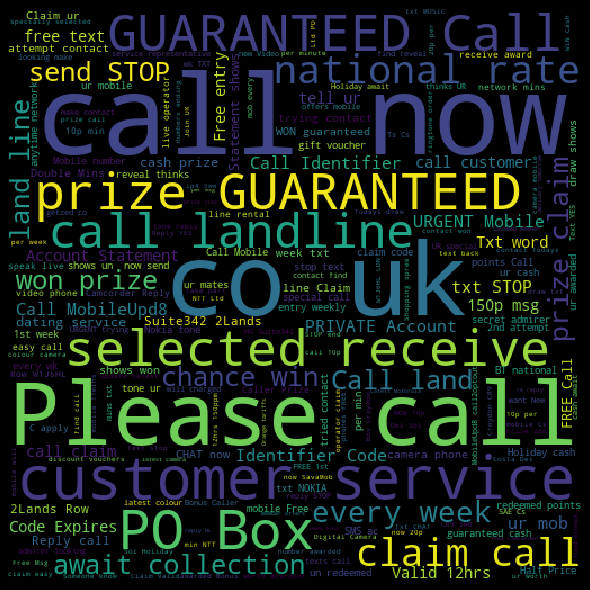

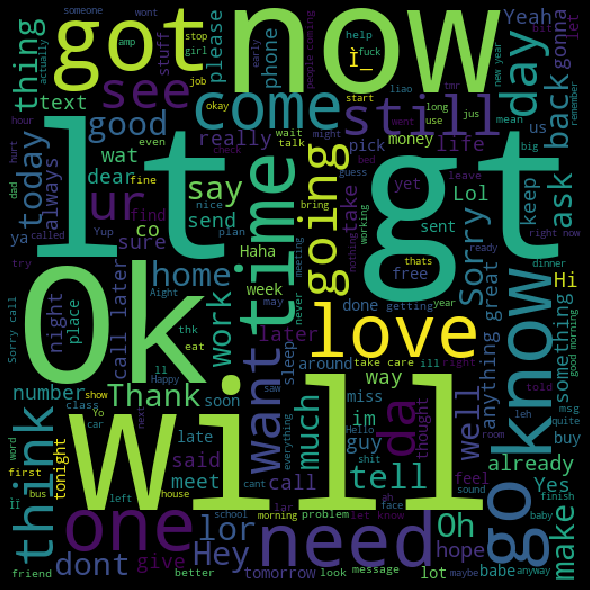

In [82]:
plot_wordcloud(data, 1)
plot_wordcloud(data, 0)

In [83]:
# calculate accurecy
def calculate_accurecy(y_pred_pro, y_true, y_pred):   
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    F1 = 2*(precision*recall)/(precision+recall)
    roc = roc_auc_score(y_true, y_pred_pro)
    print('accuracy:%.5f'%accuracy)
    print('recall:%.5f'%recall)
    print('precision:%.5f'%precision)
    print('F1:%.5f'%F1)
    print('ROC:%.5f'%roc)
    return accuracy, recall, precision, F1, roc

def ConfusionMatrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm,['Ham', 'Spam'], ['Ham','Spam'])                      
    f, ax = plt.subplots(figsize=(6, 4))
    sn.heatmap(cm_df, annot=True, fmt="d")
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    

In [89]:
def model_logistic(X_train, X_test, y_train, y_test):
#     vectorizer = TfidfVectorizer("english")
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
#     model = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train,y_train)
    model = LogisticRegression(solver='liblinear').fit(X_train,y_train)

    print('\n --- Training Acuurecy---\n')
    y_pred = model.predict(X_train)
    y_pred_pro = model.predict_proba(X_train)[:, 1]
    calculate_accurecy(y_pred_pro, y_train, y_pred)
    print('\n --- Test Acuurecy---\n')
    y_pred = model.predict(X_test)
    y_pred_pro = model.predict_proba(X_test)[:, 1]
    calculate_accurecy(y_pred_pro, y_test, y_pred)
    title = "Confusion Matrix (Logistic Regression)"
    ConfusionMatrix(y_test, y_pred, title)
    return model, vectorizer

def model_randomForest(X_train, X_test, y_train, y_test):
#     vectorizer = TfidfVectorizer("english")
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    model = RandomForestClassifier().fit(X_train,y_train)

    print('\n --- Training Acuurecy---\n')
    y_pred = model.predict(X_train)
    y_pred_pro = model.predict_proba(X_train)[:, 1]
    calculate_accurecy(y_pred_pro, y_train, y_pred)
    print('\n --- Test Acuurecy---\n')
    y_pred = model.predict(X_test)
    y_pred_pro = model.predict_proba(X_test)[:, 1]
    calculate_accurecy(y_pred_pro, y_test, y_pred)
    title = "Confusion Matrix (Logistic Regression)"
    ConfusionMatrix(y_test, y_pred, title)
    return model, vectorizer

In [85]:
def remove_punctuations(data_input):
    exclude = set(string.punctuation)
    tx = list()
    for xx in data_input:
        text = ''.join([ch for ch in xx if ch not in exclude])
        tx.append(text)
    return pd.Series(tx)

def remove_number(data_input):
    tx = list()
    for xx in data_input:
        text = ''.join([i for i in xx if not i.isdigit()])
        tx.append(text)
    return pd.Series(tx)

def separate_number_string(data_input):
    import re
    txt = list()
    for xx in data_input:
        tlist = list()
        for s in xx.split():
            tx = ' '.join([i for i in re.split(r'(\d+)', s) if i])
            tlist.append(tx)
        txt0 = ' '.join(tlist)
        txt.append(txt0)
    return pd.Series(txt)

def remove_stop_word(data_input):
    stop_word = set(stopwords.words('english'))
    tx = list()
    for xx in data_input:
        text = ' '.join([word for word in xx.split() if word.lower() not in stop_word])
        tx.append(text)
    return pd.Series(tx)

def Stemmer_Porter(data_input):
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    tx = list()
    for xx in data_input:
        tex = ' '.join([ps.stem(word) for word in xx.split()])
        tx.append(tex)
    return pd.Series(tx)

def Stemmer_Snowball(data_input):
    from nltk.stem.snowball import SnowballStemmer
    snow = SnowballStemmer("english")
    tx = list()
    for xx in data_input:
        tex = ' '.join([snow.stem(word) for word in xx.split()])
        tx.append(tex)
    return pd.Series(tx)

def Stemmer_Lancaster(data_input):
    from nltk.stem.lancaster import LancasterStemmer
    lan = LancasterStemmer()
    tx = list()
    for xx in data_input:
        tex = ' '.join([lan.stem(word) for word in xx.split()])
        tx.append(tex)
    return pd.Series(tx)

def Stemmer_WordNetLemmatizer(data_input):
    from nltk.stem import WordNetLemmatizer 
    lemmatizer = WordNetLemmatizer() 
    tx = list()
    for xx in data_input:
        tex = ' '.join([lemmatizer.lemmatize(word) for word in xx.split()])
        tx.append(tex)
    return pd.Series(tx)

In [86]:
def pre_process(stemmer_lists, email_input):
    for stremmer in stemmer_lists:
        email_input = stremmer(email_input)

    return email_input



 --- Training Acuurecy---

accuracy:0.99978
recall:0.99978
precision:0.99978
F1:0.99978
ROC:1.00000

 --- Test Acuurecy---

accuracy:0.99978
recall:0.99978
precision:0.99978
F1:0.99978
ROC:1.00000


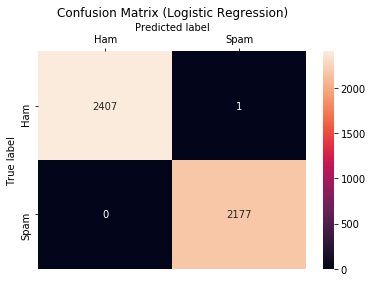

In [88]:
stemmer_lists = [remove_punctuations, remove_stop_word, separate_number_string, Stemmer_Porter, Stemmer_WordNetLemmatizer]
X = pre_process(stemmer_lists, data['message'])
# # X = data['message']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)
model, vectorizer = model_logistic(X_train, X_test, y_train, y_test)
# model, vectorizer = model_randomForest(X_train, X_test, y_train, y_test)


In [58]:
## Check Single email/SMS
tx00 = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
tx01 = pd.Series(tx00)
X_check = pre_process(stemmer_lists, tx01)
text_vect = vectorizer.transform(X_check)
prediction = model.predict(text_vect)
print("The Email is: ", tx00, '\n')
# print("The Email is: ", X_check, '\n')
print('This Email is', 'NOT SPAM' if prediction == 0 else 'SPAM')


The Email is:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's 

This Email is SPAM


In [40]:
X_test_vec = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vec)

In [41]:
## False-Positive 
X_test[(y_pred == 0) & (y_test == 1)]

10486    goal arsen 4 henri 7 v liverpool 2 henri score...
1662     Hi ur lookin 4 sauci daytim fun wiv busti marr...
9434     free msg ringtonefrom httptm widelivecomindex ...
2246     Hi ya babe x u 4 goten bout scammer get smartt...
7235     Hi ur lookin 4 sauci daytim fun wiv busti marr...
5370     datingi two start sent text talk sport radio l...
54       sm ac sptv new jersey devil detroit red wing p...
9641     tbspersolvo chase u sinc sept for£ 38 definit ...
6846           network oper servic free Cs visit 80488 biz
3860     free msg ringtonefrom httptm widelivecomindex ...
3528     xma new year eve ticket sale club day 10 am ti...
4912     goal arsen 4 henri 7 v liverpool 2 henri score...
1273           network oper servic free Cs visit 80488 biz
4067     tbspersolvo chase u sinc sept forå£ 38 definit...
7819     Hi ya babe x u 4 goten bout scammer get smartt...
9102     xma new year eve ticket sale club day 10 am ti...
10944    datingi two start sent text talk sport radio l.

The Uper Sampler:  RandomOverSampler

 --- Training Acuurecy---

accuracy:0.99979
recall:0.99979
precision:0.99979
F1:0.99979
ROC:1.00000

 --- Test Acuurecy---

accuracy:0.99938
recall:0.99938
precision:0.99938
F1:0.99938
ROC:1.00000
 
The Uper Sampler:  SMOTE


ValueError: could not convert string to float: 'hamster dead hey tmr meet 1 pm orchard mrt'

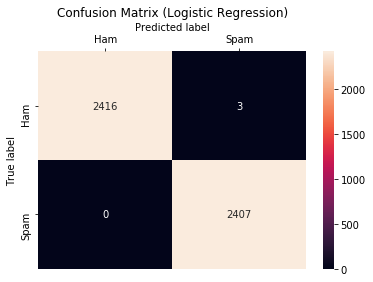

In [91]:
# imbalanced data SMOTE
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE,KMeansSMOTE, BorderlineSMOTE, SMOTENC, SVMSMOTE 
resmaplers = [('RandomOverSampler', RandomOverSampler() ), 
#           ('ADASYN', ADASYN() ),
          ('SMOTE', SMOTE( ) )
#           ('KMeansSMOTE', KMeansSMOTE(random_state=42) ), 
#           ('BorderlineSMOTE', BorderlineSMOTE(random_state=42) ), 
#           ('SMOTENC', SMOTENC(random_state=42, categorical_features=[18, 19]) ) 
#           ('SVMSMOTE', SVMSMOTE(random_state=42) ) 
         ]
X_imb = X.to_numpy().reshape(-1,1)
y_imb = y.to_numpy().reshape(-1,1)

for name, resmapler in resmaplers:
    print('The Uper Sampler: ', name)
    X_blanced, y_blanced = resmapler.fit_resample(X_imb, y_imb)
    X_train, X_test, y_train, y_test = train_test_split(X_blanced, y_blanced, random_state=5)
    X_train = X_train.reshape(-1)
    X_test = X_test.reshape(-1)
    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)
    model, vectorizer = model_logistic(X_train, X_test, y_train, y_test)
    print(" ")
# X_imb.shape  